## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import numpy as np

In [2]:
url = "http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222"

r = requests.get(url)
html = r.text

In [3]:
soup = BeautifulSoup(html, "lxml")

In [4]:
refs = soup.find_all("a")

### Цифровые нужно было?

In [5]:
uik_refs = []
names = []
for ref in refs:
    if "Территориальная избирательная комиссия" in ref.text: #or "Цифровые избирательные участки" in ref.text
        uik_refs.append(urljoin(url, ref.get("href")))
        names.append(ref.text)

In [6]:
refs_dict = dict(zip(names, uik_refs))

In [7]:
table = soup.find_all("table")[-2]
rows = table.find_all("tr")
dataa = []
for row in rows:
    cols = row.find_all("td")
    cols = [ele.text.strip() for ele in cols]
    dataa.append([ele for ele in cols if ele])
dataa.remove(dataa[12])


In [8]:
idxs = [d[1] for d in dataa[1:]]

In [9]:
refs_names = []
all_data = []
df = pd.DataFrame()
for name, ref in refs_dict.items():
    req = requests.get(ref)
    soup_ref = BeautifulSoup(req.text, "lxml")
    table = soup_ref.find_all("table")[-1]
    rows = table.find_all("tr")
    data_ref = []
    for row in rows[0:1]:
        cols = row.find_all("td")
        cols = [ele.text.strip() for ele in cols]
        col_names = [ele for ele in cols if ele]
    for row in rows[1:]:
        cols = row.find_all("td")
        cols = [ele.text.strip() for ele in cols]
        data_ref.append(np.array([int(ele.split("\n")[0]) for ele in cols if ele]))
    data_ref.remove(data_ref[11])
    if not df.empty:
        df_2 = pd.DataFrame(data_ref, columns=pd.MultiIndex.from_tuples(zip([name]*len(col_names), col_names)), index=idxs)
        df = pd.concat([df, df_2], axis=1)
    else:
        df = pd.DataFrame(data_ref, columns=pd.MultiIndex.from_tuples(zip([name]*len(col_names), col_names)), index=idxs)


/home/yura/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [10]:
df.T.to_csv("electionsT.csv")

In [11]:
df.T

Число избирателей, внесенных в список избирателей на момент окончания голосования  \
Территориальная избирательная комиссия №1  УИК №1                                                  1803                                   
                                           УИК №2                                                  1466                                   
                                           УИК №3                                                  2092                                   
                                           УИК №4                                                  1056                                   
                                           УИК №5                                                  1827                                   
...                                                                                                 ...                                   
Территориальная избирательная комиссия №30 УИК №2350                                                284                                   
                                           УИК №2351                                                132                                   
                                           УИК №2352                                                320                                   
                                           УИК №2355                                                485                                   
                                           УИК №2356                                                620                                   

                                                      Число избирательных бюллетеней, полученных участковой избирательной комиссией  \
Территориальная избирательная комиссия №1  УИК №1                                                  1200                               
                                           УИК №2                                                  1100                               
                                           УИК №3                                                  1600                               
                                           УИК №4                                                  1000                               
                                           УИК №5                                                  1400                               
...                                                                                                 ...                               
Территориальная избирательная комиссия №30 УИК №2350                                                300                               
                                           УИК №2351                                                150                               
                                           УИК №2352                                                350                               
                                           УИК №2355                                                500                               
                                           УИК №2356                                                650                               

                                                      Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования  \
Территориальная избирательная комиссия №1  УИК №1                                                   587                                                     
                                           УИК №2                                                   433                                                     
                                           УИК №3                                                   576                                                     
                                           УИК №4                                                   318                                 

In [12]:
df_t = pd.read_csv("electionsT.csv", index_col=[0,1])

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

#### явку (%) по всем ТИК, результат отсортировать по убыванию

In [13]:
lvl0_group = df_t.groupby(level=0).sum()

In [14]:
((lvl0_group["Число избирательных бюллетеней, полученных участковой избирательной комиссией"] - \
lvl0_group["Число погашенных избирательных бюллетеней"]) / \
lvl0_group["Число избирателей, внесенных в список избирателей на момент окончания голосования"]*100).sort_values(ascending=False)

Территориальная избирательная комиссия №18    51.531228
Территориальная избирательная комиссия №15    40.013072
Территориальная избирательная комиссия №13    39.674695
Территориальная избирательная комиссия №19    37.813081
Территориальная избирательная комиссия №8     36.040981
Территориальная избирательная комиссия №20    33.780554
Территориальная избирательная комиссия №9     33.528545
Территориальная избирательная комиссия №22    32.489937
Территориальная избирательная комиссия №30    32.102011
Территориальная избирательная комиссия №2     31.787913
Территориальная избирательная комиссия №1     31.483272
Территориальная избирательная комиссия №29    30.770507
Территориальная избирательная комиссия №10    30.517413
Территориальная избирательная комиссия №4     30.431840
Территориальная избирательная комиссия №7     29.254120
Территориальная избирательная комиссия №21    29.138204
Территориальная избирательная комиссия №25    29.020921
Территориальная избирательная комиссия №17    28

#### выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат (%, учитывать участки на которых проголосовало больше 100 человек)

In [15]:
lvl1_group = df_t.groupby(level=1).sum()

In [16]:
votes = lvl1_group["Число избирательных бюллетеней, полученных участковой избирательной комиссией"] - \
lvl1_group["Число погашенных избирательных бюллетеней"]

In [17]:
(lvl1_group['Амосов Михаил Иванович'] / votes).where(votes > 100).sort_values(ascending=False)[:1]

УИК №567    0.415241
dtype: float64

#### найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна

In [18]:
lvl0 = df_t.groupby(level=0)

In [19]:
turnout = (df_t["Число избирательных бюллетеней, полученных участковой избирательной комиссией"] - \
df_t["Число погашенных избирательных бюллетеней"]) / \
df_t["Число избирателей, внесенных в список избирателей на момент окончания голосования"]*100

In [20]:
gb_lvl0 = turnout.groupby(level=0)

In [21]:
(gb_lvl0.max() - gb_lvl0.min()).idxmax()

'Территориальная избирательная комиссия №17'

#### посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)

In [22]:
turnout = (df_t["Число избирательных бюллетеней, полученных участковой избирательной комиссией"] - \
df_t["Число погашенных избирательных бюллетеней"]) / \
df_t["Число избирателей, внесенных в список избирателей на момент окончания голосования"]*100

In [23]:
gb_lvl0 = turnout.groupby(level=0)

In [24]:
gb_lvl0.var()

Территориальная избирательная комиссия №1     193.184714
Территориальная избирательная комиссия №10     74.085624
Территориальная избирательная комиссия №11    239.447743
Территориальная избирательная комиссия №12     33.216038
Территориальная избирательная комиссия №13    393.430748
Территориальная избирательная комиссия №14     30.748839
Территориальная избирательная комиссия №15    416.091984
Территориальная избирательная комиссия №16    113.494498
Территориальная избирательная комиссия №17    329.320336
Территориальная избирательная комиссия №18    230.685827
Территориальная избирательная комиссия №19    204.672670
Территориальная избирательная комиссия №2     460.179400
Территориальная избирательная комиссия №20    173.571502
Территориальная избирательная комиссия №21    310.192578
Территориальная избирательная комиссия №22    450.049979
Территориальная избирательная комиссия №23    586.620917
Территориальная избирательная комиссия №24    271.130333
Территориальная избирательная к

#### для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат

In [25]:
forms = df_t["Число недействительных избирательных бюллетеней"]+df_t["Число действительных избирательных бюллетеней"]
for cand in ["Амосов Михаил Иванович", "Беглов Александр Дмитриевич", "Тихонова Надежда Геннадьевна"]:
    percent = np.around(df_t[cand].sum() / forms.sum() * 100)
    cand_uk = np.around(df_t[cand] / forms * 100)
    print(cand, percent, (cand_uk == percent).sum())

Амосов Михаил Иванович 16.0 153
Беглов Александр Дмитриевич 64.0 90
Тихонова Надежда Геннадьевна 17.0 188


#### визуализируйте отношение - явка на УИК  →  результат кандидата

In [26]:
import matplotlib.pyplot as plt

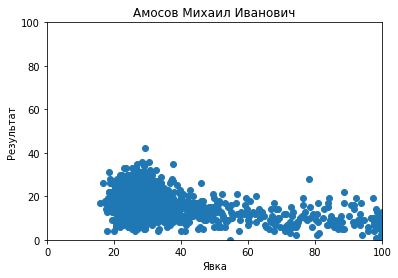

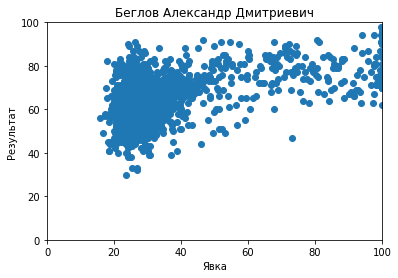

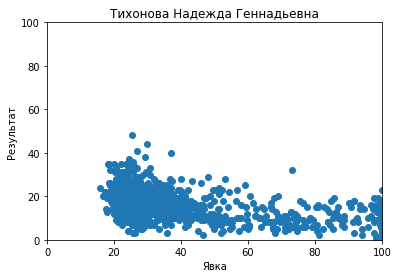

In [27]:
forms = (df_t["Число недействительных избирательных бюллетеней"]+df_t["Число действительных избирательных бюллетеней"]) 
turnout = forms / df_t["Число избирателей, внесенных в список избирателей на момент окончания голосования"] * 100

for cand in ["Амосов Михаил Иванович", "Беглов Александр Дмитриевич", "Тихонова Надежда Геннадьевна"]:
    cand_uk = np.around(df_t[cand] / forms * 100)
    plt.figure()
    plt.title(cand)
    plt.xlim((0,100))
    plt.xlabel("Явка")
    plt.ylim((0,100))
    plt.ylabel("Результат")
    plt.scatter(turnout, cand_uk)
    plt.show()